### Import required libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from time import time
from torch import nn, optim
import torch.nn.functional as F
from tqdm import tqdm
import os
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
import re


### Text preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')
emails_df = pd.read_csv("gdrive/My Drive/Method attack/Project - spam detection/emails.csv")
emails_df.columns = ["text", "label"]

def preprocess_and_extract_features(emails_df):
    tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X = tfidf_vectorizer.fit_transform(emails_df['text']).toarray()
    y = LabelEncoder().fit_transform(emails_df['label'])
    return X, y

X, y = preprocess_and_extract_features(emails_df)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


### Feature extraction

In [3]:
# Function to check presence of HTML tags
def has_html_tags(text):
    return int(bool(re.search(r'<[^>]+>', text)))

# Function to extract word frequency features using CountVectorizer
def extract_word_frequency_features(emails_df):
    count_vectorizer = CountVectorizer(stop_words='english', max_features=1000)
    X_count = count_vectorizer.fit_transform(emails_df['text']).toarray()
    return X_count

# Function to extract HTML tag presence feature
def extract_html_features(emails_df):
    additional_features = np.zeros((emails_df.shape[0], 1))

    for i, text in enumerate(emails_df['text']):
        additional_features[i, 0] = has_html_tags(text)

    return additional_features

# Function to extract TF-IDF features
def extract_tfidf_features(emails_df):
    tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X_tfidf = tfidf_vectorizer.fit_transform(emails_df['text']).toarray()
    return X_tfidf

# Function to encode labels
def encode_labels(emails_df):
    y = LabelEncoder().fit_transform(emails_df['label'])
    return y



### Build a model structure

In [4]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_model(model, X, y, optimizer, criterion, epochs=60):
    model.train()
    losses = []
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    return model, losses

def evaluate_model(model, X, y, criterion):
    model.eval()
    with torch.no_grad():
        y_pred = model(X)
        loss = criterion(y_pred, y)
        y_pred_label = torch.argmax(y_pred, dim=1).item()
        correct = (y_pred_label == y.item())
    return correct, loss, y_pred_label

# Combine predictions
def combined_accuracy(word_freq_predictions,tfidf_predictions):
  final_predictions = []
  for i in range(len(y_eval)):
      if word_freq_predictions[i] == 1 or tfidf_predictions[i] == 1:
          final_predictions.append(1)
      else:
          final_predictions.append(0)
  final_correct_predictions = sum([1 if final_predictions[i] == y_eval[i].item() else 0 for i in range(len(y_eval))])
  final_accuracy = final_correct_predictions / len(y_eval)
  return final_accuracy

def run_experiment(X_train, X_eval, y_train, y_eval, input_size):
    model = MLPModel(input_size, hidden_size, output_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train
    model, losses = train_model(model, X_train.to(device), y_train.to(device), optimizer, criterion, epochs=60)

    # Evaluation
    predictions = []
    correct_predictions = 0
    total_loss = 0
    for i in range(len(X_eval)):
        X_test = X_eval[i].reshape(1, -1)
        y_test = y_eval[i].reshape(1)
        correct, loss, y_pred_label = evaluate_model(model, X_test.to(device), y_test.to(device), criterion)
        predictions.append(y_pred_label)
        correct_predictions += correct
        total_loss += loss

    accuracy = correct_predictions / len(X_eval)
    average_loss = total_loss / len(X_eval)
    return predictions, accuracy, average_loss, model, losses




### Create the model and split the data

In [5]:
hidden_size = 128
output_size = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Prepare data for each model
X_word_freq = extract_word_frequency_features(emails_df)
X_tfidf = extract_tfidf_features(emails_df)
y = encode_labels(emails_df)

# Prepare training data
train_indices = np.concatenate((np.arange(0, 800), np.arange(1400, 2100), np.arange(2200, 3700)))
np.random.shuffle(train_indices)
X_train_word_freq = X_word_freq[train_indices]
X_train_tfidf = X_tfidf[train_indices]
y_train = y[train_indices]

# Convert to torch tensors for training data
X_train_word_freq = torch.tensor(X_train_word_freq, dtype=torch.float32)
X_train_tfidf = torch.tensor(X_train_tfidf, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)



# Prepare evaluation data
eval_indices = np.concatenate((np.arange(1100, 1200), np.arange(2100, 2200)))
np.random.shuffle(eval_indices)
X_eval_word_freq = X_word_freq[eval_indices]
X_eval_tfidf = X_tfidf[eval_indices]
y_eval = y[eval_indices]


# Convert evaluation data to torch tensors
X_eval_word_freq = torch.tensor(X_eval_word_freq, dtype=torch.float32)
X_eval_tfidf = torch.tensor(X_eval_tfidf, dtype=torch.float32)
y_eval = torch.tensor(y_eval, dtype=torch.long)




### Train and evaluate the model

In [6]:
# Calculate the 'Word Frequency' features model accuracy
print("Word Frequency Model")
word_freq_predictions, word_freq_accuracy, word_freq_loss, modelFrequency, word_freq_losses = run_experiment(X_train_word_freq, X_eval_word_freq, y_train, y_eval, X_train_word_freq.shape[1])
print(f"Word Frequency Model Accuracy: {word_freq_accuracy:.4f}, Loss: {word_freq_loss:.4f}")

# Calculate the 'TF-IDF' features model accuracy
print()
print("TF-IDF Features Model")
tfidf_predictions, tfidf_accuracy, tfidf_loss, modelTFIDF, tfidf_losses = run_experiment(X_train_tfidf, X_eval_tfidf, y_train, y_eval, X_train_tfidf.shape[1])
print(f"TF-IDF Features Model Accuracy: {tfidf_accuracy:.4f}, Loss: {tfidf_loss:.4f}")

# Calculate the combined model accuracy
print()
final_accuracy = combined_accuracy(word_freq_predictions,tfidf_predictions)
print(f"Final Combined Model Accuracy: {final_accuracy:.4f}")


Word Frequency Model


100%|██████████| 60/60 [00:00<00:00, 90.67it/s] 


Word Frequency Model Accuracy: 0.9800, Loss: 0.1371

TF-IDF Features Model


100%|██████████| 60/60 [00:00<00:00, 464.87it/s]


TF-IDF Features Model Accuracy: 0.9700, Loss: 0.0719

Final Combined Model Accuracy: 0.9750


### Plot the training losses

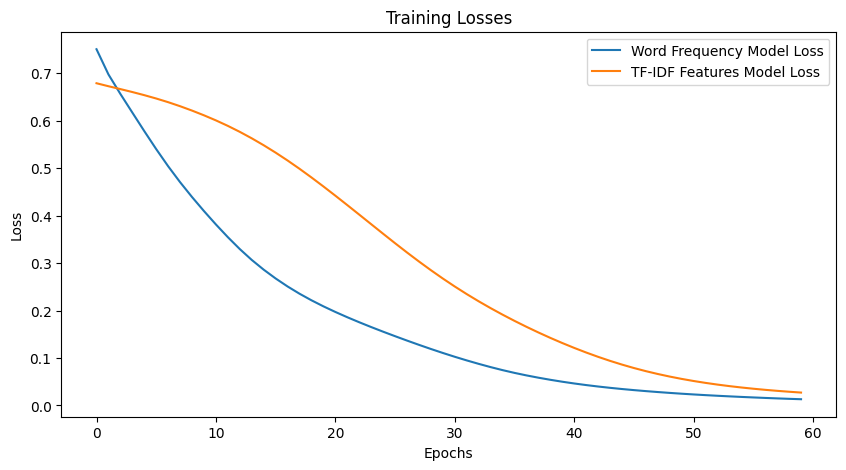

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(word_freq_losses, label='Word Frequency Model Loss')
plt.plot(tfidf_losses, label='TF-IDF Features Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

### External Dataset Example and Model Testing

In [8]:
spam_messge = """
Dear John,

We have noticed some unusual activity on your account and require you to verify your information immediately. Failure to do so may result in the suspension of your account. Please click on the link below to verify your account details:

[Click here to verify your account](http://scamwebsite.com/verify)

Thank you for your prompt attention to this matter.

Sincerely,
The Support Team

"""

non_spam_message = """
Hi John,

I hope this email finds you well. I wanted to confirm our meeting scheduled for next Tuesday at 10 AM. We will be discussing the new project plans and next steps for our team.

Please let me know if this time works for you or if we need to reschedule.

Best regards,
Jane Smith
Project Manager

"""

In [9]:

# Preprocess
def preprocess_single_email(text):
    word_freq_vectorizer = CountVectorizer(stop_words='english', max_features=1000)
    word_freq_vectorizer.fit(emails_df['text'])
    X_word_freq = word_freq_vectorizer.transform([text]).toarray()

    tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf_vectorizer.fit(emails_df['text'])
    X_tfidf = tfidf_vectorizer.transform([text]).toarray()

    return X_word_freq, X_tfidf

# Function to get prediction from a single model
def get_prediction(model, X):
    with torch.no_grad():
        y_pred = model(X)
        y_pred_label = torch.argmax(y_pred, dim=1).item()
    return y_pred_label

def evaluate_model_one_example(email_message):
  X_word_freq_single, X_tfidf_single = preprocess_single_email(email_message)

  # Convert to torch tensors
  X_word_freq_single = torch.tensor(X_word_freq_single, dtype=torch.float32).to(device)
  X_tfidf_single = torch.tensor(X_tfidf_single, dtype=torch.float32).to(device)

  # Get predictions from each model
  word_freq_pred = get_prediction(modelFrequency, X_word_freq_single)
  tfidf_pred = get_prediction(modelTFIDF, X_tfidf_single)
  final_pred = 1 if (word_freq_pred == 1  or tfidf_pred == 1) else 0

  return word_freq_pred, tfidf_pred, final_pred

def print_findings(word_freq_pred, tfidf_pred, final_pred):
  print(f"Word Frequency Model Prediction: {word_freq_pred}")
  print(f"TF-IDF Features Model Prediction: {tfidf_pred}")
  print(f"Final Combined Prediction: {final_pred}")

# Print results
print("Spam message: ")
word_freq_pred, tfidf_pred, final_pred = evaluate_model_one_example(spam_messge)
print_findings(word_freq_pred, tfidf_pred, final_pred )

print()
print("Non spam message: ")
word_freq_pred, tfidf_pred, final_pred = evaluate_model_one_example(non_spam_message)
print_findings(word_freq_pred, tfidf_pred, final_pred )

Spam message: 
Word Frequency Model Prediction: 1
TF-IDF Features Model Prediction: 1
Final Combined Prediction: 1

Non spam message: 
Word Frequency Model Prediction: 0
TF-IDF Features Model Prediction: 0
Final Combined Prediction: 0
